In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd, numpy as np

from astropy.table import Table
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

from math import pi
import pickle, os

from scipy.interpolate import interp1d

global COLORS
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

from plot_cluster_positions import get_cluster_data

import matplotlib as mpl, seaborn as sns
%matplotlib inline

In [2]:
close, far, df = get_cluster_data()

**************************************************

Milky Way Star Clusters (close := <500pc)
N_clusters: 86
N_stars (in core): 691
N_stars (in central part): 10468
N_stars (in cluster): 32200

**************************************************

Milky Way Star Clusters (far := <1000pc)
N_clusters: 361
N_stars (in core): 2390
N_stars (in central part): 31727
N_stars (in cluster): 94959

**************************************************


In [3]:
df.columns

Index(['_RAJ2000', '_DEJ2000', 'map', 'cmd', 'stars', 'MWSC', 'Name', 'Type',
       'n_Type', 'RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'r0', 'r1', 'r2',
       'pmRA', 'pmDE', 'e_pm', 'RV', 'e_RV', 'o_RV', 'N1sr0', 'N1sr1', 'N1sr2',
       'd', 'E_B-V_', 'MOD', 'E_J-Ks_', 'E_J-H_', 'dH', 'logt', 'e_logt', 'Nt',
       'rc', 'e_rc', 'rt', 'e_rt', 'k', 'e_k', 'Src', 'SType', '__Fe_H_',
       'e__Fe_H_', 'o__Fe_H_', 'Simbad', 'mean_N_star_per_sqdeg',
       'galactic_long', 'galactic_lat', 'ecliptic_long', 'ecliptic_lat'],
      dtype='object')

In [4]:
coord = 'ecliptic'

In [5]:
# set things up for TESS footprint

dat = np.genfromtxt('../data/shemi_nhemi.csv', delimiter=',')
dat = pd.DataFrame(np.transpose(dat), columns=['icSys', 'tSys', 'teff',
    'logg', 'r', 'm', 'eLat', 'eLon', 'micSys', 'mvSys', 'mic', 'mv',
    'stat', 'nPntg'])
eLon, eLat = np.array(dat.eLon), np.array(dat.eLat)
nPntg = np.array(dat.nPntg)
if coord=='galactic':
    c = SkyCoord(lat=eLat*u.degree, lon=eLon*u.degree,
            frame='barycentrictrueecliptic')
    lon = np.array(c.galactic.l)
    lat = np.array(c.galactic.b)

elif coord=='ecliptic':
    lon, lat = eLon, eLat

nPntg[nPntg >= 4] = 4

ncolor = 4
cmap1 = mpl.colors.ListedColormap(
        sns.color_palette("Greys", n_colors=ncolor, desat=1))
bounds= list(np.arange(0.5,ncolor+1,1))
norm1 = mpl.colors.BoundaryNorm(bounds, cmap1.N)

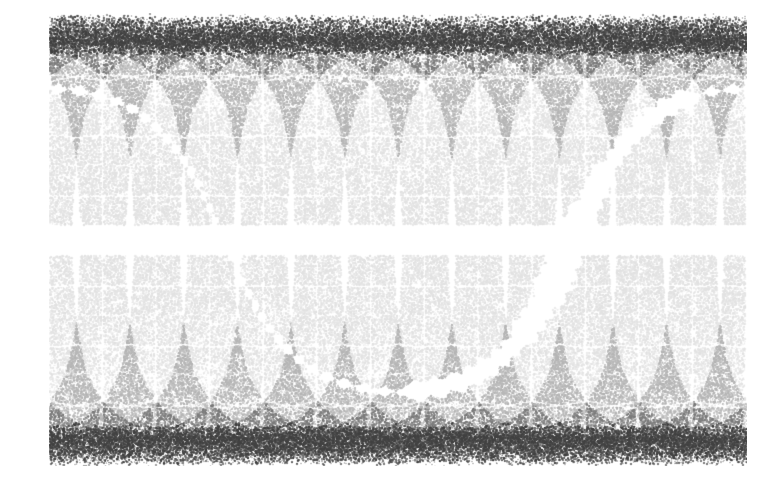

In [6]:
# MAKES THE SHITTY SKYMAP IMAGE THAT I THEN SCALED TO 900x600 IN GIMP

my_dpi=100

plt.close('all')

fig, ax = plt.subplots(
          figsize=(900/my_dpi, 600/my_dpi), dpi=my_dpi
          )

plt.axis('off')

ax.scatter(lon, lat, s=0.2, marker='s', c=nPntg, zorder=1, cmap=cmap1,
          norm=norm1, rasterized=True, alpha=0.5)

ax.set_xlim([0,360])
ax.set_ylim([-90,90])

fig.savefig('background_skymap.png',
            dpi=my_dpi,
            pad_inches=0.
            )

the above was rescaled with GIMP, bc omg wtf matplotlib

load up bokeh...

In [7]:
from bokeh.plotting import ColumnDataSource, figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

create bokeh source dataframe

In [8]:
filter_list = ['ecliptic_long', 'ecliptic_lat',
               'galactic_long', 'galactic_lat',
               'Name', 'Type', 'd', 'N1sr1',
               'N1sr2', 'logt', 'r1', 'r2']

fdf = df.filter(items=filter_list)

source = ColumnDataSource(fdf)

put it all together

In [9]:
fig = figure(tools="pan,wheel_zoom,box_zoom,reset",
             active_scroll="wheel_zoom",
             x_axis_type="linear",
             x_range=[0.0, 360],
             y_range=[-90,90]
            )

# import background
from scipy.misc import imread
img = imread('background_skymap_scaled.png', mode='RGBA')

fig.image_rgba(image=[img], x=[0], y=[-90], dw=[360], dh=[180])

# overlay MWSC points
oc_render = fig.circle('ecliptic_long',
                       'ecliptic_lat',
                       source=source,
                       size=7)

#weight = np.log10(fdf['N1sr2'])/np.max(np.log10(fdf['N1sr2']))
weight = fdf['N1sr2']/np.sort(fdf['N1sr2'])[-40]
source.add(weight, name='weight')
oc_render.data_source = source
oc_render.glyph.fill_alpha = 'weight'
oc_render.glyph.line_alpha = 0.1

from bokeh.models import HoverTool
hover = HoverTool(renderers=[oc_render],
        tooltips=[
        ("name", "@Name"),
        ("dist", "@d{1.1} pc"),
        ("log(t [yr])", "@logt{1.1}"),
        ("ang radius", "@r2 deg"),
        ("central ang radius", "@r1 deg"),
        ("N in ang radius", "@N1sr2"),
        ("N in central ang radius", "@N1sr1")
        ]
    )
fig.add_tools(hover)

# let clicking google it for you
links = ['https://www.google.com/search?q='+name for name in fdf['Name']]
from bokeh.models import TapTool, OpenURL
fig.add_tools(TapTool())
source.add(links, name='inks')
oc_render.data_source = source
oc_
url = "@pl_pelink"
taptool = fig.select(type=TapTool)
taptool.callback = OpenURL(url=url)


fig.xaxis.axis_label = 'ecl longitude'
fig.yaxis.axis_label = 'ecl latitude'
fig.xaxis.axis_label_text_font_size = '14pt'
fig.xaxis.major_label_text_font_size = '12pt'
fig.yaxis.axis_label_text_font_size = '14pt'   
fig.yaxis.major_label_text_font_size = '12pt' 
fig.toolbar_location = "above"

fig.plot_height=600
fig.plot_width=900

show(fig)

In [10]:
from bokeh.plotting import output_file, save
output_file('bokeh_interactive_cluster_positions.html')
save(fig)

'/home/luke/Dropbox/proj/star_clusters/src/bokeh_interactive_cluster_positions.html'

## experimented down here, found out that no, you can't plot 200k points, and unsurprisingly, building a polygon tess view map would be a pain in the ass